# prep

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
from tqdm import tqdm
from IPython.display import clear_output

import os
import pickle

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

In [31]:
dir_inter = r'Z:\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
dir_file = os.path.join(dir_inter, 'adp_dataset_master.xlsx')
data_info = pd.read_excel(dir_file)
data_info.tail()

meta = data_info[(data_info.paradigm == 'grating_8ori_multisess')]
# meta = data_info[(data_info.paradigm == 'grating') 
                #  & (data_info.area == 'LM')
                #  & ((data_info.cellpose_seg == True) | (data_info.manual_seg == True))] # ensure segmentation
meta = meta.reset_index(drop=True)
nset = meta.shape[0]
print(meta.area.value_counts(), nset)
meta

V1    3
Name: area, dtype: int64 3


,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1380,230622,V1,NaN,002,NaN,NaN,grating_8ori_multisess,6s,NaN,NaN
1,1380,230622,V1,NaN,003,NaN,NaN,grating_8ori_multisess,6s,NaN,NaN
2,1380,230622,V1,NaN,004,NaN,NaN,grating_8ori_multisess,6s,NaN,NaN


# batch write df_tidy
revised to match mulstisess

In [43]:
nset = meta.date.nunique()
for iset in tqdm(range(nset)):
    print(f'iset={iset}, nset={nset}')


    ## load data
    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = meta.loc[iset, 'num']
    # print(mouse, date, area, sess)
    # dir_identifier = f'{area}_{imouse}_{date}_{sess}'
    dir_identifier = f'{area}_{imouse}_{date}'

    mat_inter = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    for dirname in os.listdir(mat_inter):
        if dir_identifier in dirname:
            dir_data = mat_inter + dirname
            break

    stim_id, resp_ad, resp_tg = adp.load_resp_trial(os.path.join(dir_data), vis_filter=False) # already sliced by resp time window from matlab. only differentiating isi in resp_tg by indexing into trial. match isi_nframe
    ## NOTE: stim_id contains the final trial, which should be cut off due to incomplete trial, to match trace_by_trial


    ## construct dfof
    R1_dfof = resp_ad.flatten() # cell x trial, row major flatten
    R2_dfof = resp_tg.flatten()
    dfof = np.hstack((R1_dfof, R2_dfof)) # sort by cell_id, then trial_id, finally resp_id


    ## construct cell, trial, resp id
    ncell = resp_ad.shape[0]
    ntrial = resp_ad.shape[1]
    cell_id = np.repeat(np.arange(ncell), ntrial) # repeat cell id arr for ntrial times == sort by cell_id, then trial_id
    cell_id = np.hstack((cell_id, cell_id)) # stack two copies for R1 and R2. finally sort by resp_id

    trial_id = np.tile(np.arange(ntrial), ncell) # for each cell, go over all trials
    trial_id = np.hstack((trial_id, trial_id))

    len_df = ncell * ntrial * 2 # 2 for (R1, R2)
    resp_id = ['R1'] * int(len_df/2) + ['R2'] * int(len_df/2) # first half is flattened resp_ad, second half is flattened resp_tg


    ## construct stim info col: stim 2 orientation, stim 1 orien, isi, adapter contrast
    trial_stim_orien = stim_id['stim_ori'][0] # NOTE: turns out if you save matlab row vector, it is a list of only one sublist. if column vector, it is a list of many sublists where each sublist is a single value
    trial_stim_orien_dict = {} ## map stim2 orientation to int. convert from grat ori in deg to 0-based indexing (ensured)
    print(np.sort(np.unique(trial_stim_orien)))
    assert len(np.unique(trial_stim_orien)) == 8 # ensure 8 ori
    assert min(np.unique(trial_stim_orien)) == 0
    assert max(np.unique(trial_stim_orien)) == 180-22.5
    for i, item in enumerate(np.sort(np.unique(trial_stim_orien))):
        trial_stim_orien_dict[item] = i
    trial_stim_orien_int = [trial_stim_orien_dict[item] for item in trial_stim_orien]

    trial_isi_nframe = stim_id['isi_nframe'][0]
    trial_adapter_contrast = stim_id['adapter_contrast'][0]

    trial_stim_orien_int = trial_stim_orien_int[:ntrial] # if any stim info longer than ntrial, slice off the last one
    trial_isi_nframe = trial_isi_nframe[:ntrial]
    trial_adapter_contrast = trial_adapter_contrast[:ntrial]
    

    ## make stim info col: same as trial_id - tile then hstack
    stim_id_col = np.tile(trial_stim_orien_int, ncell)
    isi_col = np.tile(trial_isi_nframe, ncell)
    ad_con_col = np.tile(trial_adapter_contrast, ncell)

    stim_id_col = np.hstack((stim_id_col, stim_id_col)) # stim2 orientation
    isi_col = np.hstack((isi_col, isi_col))
    ad_con_col = np.hstack((ad_con_col, ad_con_col))

    
    df_tidy = pd.DataFrame({'dfof': dfof, 'cell_id': cell_id, 'trial_id': trial_id, 'resp_id': resp_id, 
                            'isi': isi_col, 'stim1_contrast': ad_con_col, 
                            'stim2_id': stim_id_col,})
    df_tidy['area'] = area
    df_tidy['stim1_id'] = 0 # adapter (stim1) is always 0 deg / vertical gratings
    df_tidy.loc[(df_tidy.stim1_contrast == 0) & (df_tidy.resp_id == 'R1'), 'dfof'] = np.nan # set R1 to nan if no adapter (stim1_contrast == 0)
    df_tidy = df_tidy.dropna().reset_index(drop=True) # drop nan rows

    print(df_tidy.isi.unique()) # ensure isi 250 and 750
    assert min(df_tidy.isi.unique()) >= 7 # allow 1 frame jitter
    assert max(df_tidy.isi.unique()) <= 24
    df_tidy['isi'] = df_tidy['isi'].apply(lambda x: 250 if x <= 10 else 750) # convert isi_nframe to ms. 250 ms is about 8 frames, 750 ms is about 22-23 frames
    df_tidy.loc[df_tidy.stim1_contrast == 0, 'isi'] = 6000 # set ISI to 6000 ms (equal to ITI) if no adapter (stim1_contrast == 0)


    ## vis cell filter, well_fit filter, & img driven cell-stim filter
    df_tidy['filter_cell_vis'] = np.nan
    # df_tidy['filter_cell_well_fit'] = np.nan
    df_tidy['filter_cell_stim'] = np.nan

    with open(os.path.join(dir_data, 'vis_driven_ttest_bonferroni.pickle'), 'rb') as f: # using new vis driven filter
        filter_file = pickle.load(f)
    filter_cell_stim = filter_file['img_driven']
    filter_cell_vis = filter_file['vis_driven']

    # well_fit = sio.loadmat(os.path.join(dir_data, 'fit_bootstrap_90perc.mat'))
    # well_fit_cell = np.array([x[0] for x in well_fit['well_fit_cell']])

    for icell in np.arange(filter_cell_stim.shape[0]): # filter_cell_stim is ncell x nstim
        df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_vis'] = filter_cell_vis[icell]
        # df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit'] = well_fit_cell[icell]
        for istim in np.arange(filter_cell_stim.shape[1]):
            df_tidy.loc[(df_tidy['stim2_id']==istim) & (df_tidy['cell_id']==icell), 'filter_cell_stim'] = filter_cell_stim[icell, istim]
    # df_tidy.filter_cell_vis.value_counts(), df_tidy.filter_cell_stim.value_counts()


    # ## cell tuning in 3 possible ISI, 2 runs (each run uses half of the trials)
    # fit_tuning_half = sio.loadmat(os.path.join(dir_data, 'fit_tuning_half_trials.mat'))
    # ori_pref_run1 = fit_tuning_half['ori_pref_runs'][:, :, 0] # ncell x 3isi x 2run, [noad vs ad750 vs ad250]
    # ori_pref_run2 = fit_tuning_half['ori_pref_runs'][:, :, 1]

    # ori_pref_runs_sorted = well_fit['ori_pref_runs']
    # # ori_pref_runs_sorted = np.array([np.sort(x) for x in well_fit['ori_pref_runs']]) # ncell x nrun. sort each row of ori_pref_runs
    # # for icell in np.arange(10):
    # #     plt.plot(ori_pref_runs_sorted[icell, :])

    # percentile_threshold = 0.9
    # # if area == 'LI':
    # #     percentile_threshold = 0.7 # taken from well_fit_cell_criteria(_relax).m, only relax for LI
    # nrun = ori_pref_runs_sorted.shape[1]
    # rand_idx = np.random.randint(nrun*(1-percentile_threshold), nrun*percentile_threshold, size=2) # # bc well_fit cells are defined as: 90% of bootstrapped ori_pref within 22.5 deg, randomly select 2 indices between 100-900 in ori_pref_runs_sorted
    # ori_pref_noad1 = ori_pref_runs_sorted[:, rand_idx[0]] # ncell x 1
    # ori_pref_noad2 = ori_pref_runs_sorted[:, rand_idx[1]]


    # ## goodness of fit (R square) in isi 250 or 750
    # fit_tuning = sio.loadmat(os.path.join(dir_data, 'fit_tuning_isi3.mat')) # fit_tuning['fit_param'].shape # ncell x nparam x nstim
    # R_square = fit_tuning['fit_param'][:, -1, :] # ncell x nstim, final param is R_square of fit
    # R_square_750 = R_square[:, 1] # use R_sq to determine well_fit_ad
    # R_square_250 = R_square[:, 2]
    # well_fit_ad_250 = R_square_250 >= np.percentile(R_square_250, 50) # ncell x 1. only take top 50% of R_sq
    # well_fit_ad_750 = R_square_750 >= np.percentile(R_square_750, 50)


    # ## write cell property to df_tidy
    # ncell = df_tidy.cell_id.unique().shape[0]
    # for icell in np.arange(ncell):
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad'] = ori_pref_run1[icell, 0] # ori_pref_run1 is ncell x 3isi, [noad vs ad750 vs ad250]
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_750'] = ori_pref_run1[icell, 1]
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_ad_250'] = ori_pref_run1[icell, 2]

    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad1'] = ori_pref_run1[icell, 0] # for control plot. ori_pref_noad1 is same as ori_pref_noad
    #     df_tidy.loc[(df_tidy.cell_id == icell), 'ori_pref_noad2'] = ori_pref_run2[icell, 0] # take from another run

    #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_250'] = well_fit_ad_250[icell]
    #     df_tidy.loc[df_tidy['cell_id']==icell, 'filter_cell_well_fit_ad_750'] = well_fit_ad_750[icell]
    
    # break

    ## save df_tidy as csv
    df_tidy.to_csv(os.path.join(dir_data, 'df_tidy_grat8ori_multisess.csv'), index=False)

# clear_output()

  0%|          | 0/1 [00:00<?, ?it/s]

iset=0, nset=1
ncell: 160, nstim: 8, ntrial: 1334
[  0.   22.5  45.   67.5  90.  112.5 135.  157.5]
[ 8 23 24  9  7 22]


100%|██████████| 1/1 [00:08<00:00,  8.89s/it]


# batch load df_tidy

In [32]:
meta

,mouse,date,area,depth,num,cellpose_seg,manual_seg,paradigm,gcamp,AWS,note
0,1380,230622,V1,NaN,002,NaN,NaN,grating_8ori_multisess,6s,NaN,NaN
1,1380,230622,V1,NaN,003,NaN,NaN,grating_8ori_multisess,6s,NaN,NaN
2,1380,230622,V1,NaN,004,NaN,NaN,grating_8ori_multisess,6s,NaN,NaN


In [45]:
nset = meta.date.nunique()
df_tidy = pd.DataFrame()

for iset in range(nset):
    print(f'iset={iset}, nset={nset}')

    mouse = meta.loc[iset, 'mouse'].astype(str)
    imouse = 'i' + mouse
    date = meta.loc[iset, 'date'].astype(str)
    area = meta.loc[iset, 'area']
    # sess = meta.loc[iset, 'num']
    print(imouse, date, area, ) # sess)
    dir_identifier = f'{area}_{imouse}_{date}' #_{sess}'

    dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter/'.replace('\\', '/')
    csv_filename = 'df_tidy_grat8ori_multisess.csv'
    try:
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))
    except:
        dir_identifier = dir_identifier + '_cellpose'
        df_tidy_now = pd.read_csv(os.path.join(dir_data, dir_identifier, csv_filename))

    df_tidy_now['mouse'] = mouse
    df_tidy_now['date'] = date
    # df_tidy_now['sess'] = sess
    df_tidy_now['cell_id'] = (df_tidy_now.date.astype(str) + '_' 
                               + df_tidy_now.mouse.astype(str) + '_' # multisess doesn't matter, should append mouse id
                               + df_tidy_now.cell_id.astype(str)) # cell_id adjusted to be unique across mice, dates, sessions
    df_tidy = pd.concat([df_tidy, df_tidy_now], axis=0).reset_index(drop=True)
    # break
    
# clear_output()

iset=0, nset=1
i1380 230622 V1


In [46]:
df_tidy.groupby(['mouse', 'date']).first()

,,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_stim
mouse,date,,,,,,,,,,,
1380,230622,0.09373,230622_1380_0,0,R1,250,1,3,V1,0,True,False


In [56]:
print(df_tidy.mouse.unique(), 
      df_tidy.date.unique(), 
      # df_tidy.sess.unique(), 
      df_tidy.area.unique(), 
      df_tidy.isi.unique(), 
      df_tidy.stim1_contrast.unique(), 
      df_tidy.stim2_id.unique(), 
      df_tidy.resp_id.unique())
df_tidy.sample(5, random_state=0)

['1380'] ['230622'] ['V1'] [ 250  750 6000] [1 0] [3 5 7 6 2 0 4 1] ['R1' 'R2']


,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_stim,mouse,date
232232,-0.022498,230622_1380_62,84,R2,250,1,3,V1,0,True,False,1380,230622
248949,-0.059928,230622_1380_74,793,R2,6000,0,6,V1,0,True,False,1380,230622
186075,-0.037718,230622_1380_27,617,R2,750,1,5,V1,0,False,False,1380,230622
204064,-0.048339,230622_1380_40,1264,R2,6000,0,1,V1,0,False,False,1380,230622
326580,0.032514,230622_1380_132,1052,R2,6000,0,3,V1,0,True,False,1380,230622


# adaptation by isi

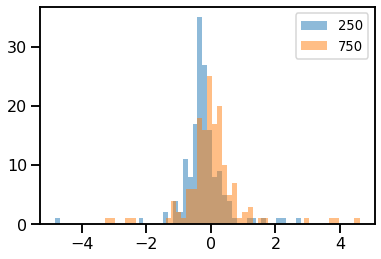

In [57]:
def adp_in_area(df_filter):

    gb_R1 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R1')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_R2 = df_filter[(df_filter.stim2_id == 0) & (df_filter.resp_id == 'R2')].groupby(['area', 'cell_id']).sum()['dfof'].values
    gb_adp = (gb_R2 - gb_R1) / (gb_R1 + 1e-7)
    gb_adp = gb_adp[np.abs(gb_adp) < 5]

    return gb_adp

df_filter = df_tidy#[df_tidy.isi == 250]
gb_adp_250 = adp_in_area(df_filter[df_filter.isi == 250])
gb_adp_750 = adp_in_area(df_filter[df_filter.isi == 750])

plt.hist(gb_adp_250, bins=50, alpha=.5, label='250')
plt.hist(gb_adp_750, bins=50, alpha=.5, label='750')
plt.legend();

# adp_mean_arr = [np.mean(gb_adp_V1), np.mean(gb_adp_LM), np.mean(gb_adp_LI)]
# adp_med_arr = [np.median(gb_adp_V1), np.median(gb_adp_LM), np.median(gb_adp_LI)]
# adp_sem_arr = [np.std(gb_adp_V1) / np.sqrt(len(gb_adp_V1)), 
#                np.std(gb_adp_LM) / np.sqrt(len(gb_adp_LM)),
#                 np.std(gb_adp_LI) / np.sqrt(len(gb_adp_LI))]
# plt.errorbar([1, 2, 3], adp_mean_arr, yerr=adp_sem_arr, label='mean', alpha=.5)
# plt.errorbar([1, 2, 3], adp_med_arr, yerr=adp_sem_arr, label='median', alpha=.5)
# plt.xticks([1, 2, 3], ['V1', 'LM', 'LI']);
# plt.ylim([-1, 0]);
# plt.legend(frameon=False);

# sns.boxplot(data=[gb_adp_250, gb_adp_750], palette='Set2', notch=True, showfliers=False) # dont show the outliers beyond the caps
# plt.xticks([0, 1], ['250', '750']);
# plt.ylabel('adaptation index');
# sns.despine();

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning bias'.replace('\\', '/')
# plt.savefig(os.path.join(dir_fig, 'adp_grat8_by_area.pdf'))

## save & reload

In [33]:
dir_df = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\df tidy for plots/'.replace('\\', '/')
csv_filename = 'df_tidy_grat8ori_multisess.csv'

# chunks = np.array_split(df_tidy.index, 100) # split into 100 chunks
# for chunk, subset in enumerate(tqdm(chunks)):
#     if chunk == 0: # first row
#         df_tidy.loc[subset].to_csv(csv_filename, mode='w', index=True)
#     else:
#         df_tidy.loc[subset].to_csv(csv_filename, header=None, mode='a', index=True)

df_tidy = pd.read_csv(os.path.join(dir_df, csv_filename), index_col=0)

# df for tuning curve

In [34]:
df_tidy

,dfof,cell_id,trial_id,resp_id,isi,stim1_contrast,stim2_id,area,stim1_id,filter_cell_vis,filter_cell_stim,mouse,date
0,0.093730,230622_1380_0,0,R1,250,1,3,V1,0,True,False,1380,230622
1,0.352953,230622_1380_0,2,R1,250,1,5,V1,0,True,True,1380,230622
2,0.270396,230622_1380_0,5,R1,250,1,3,V1,0,True,False,1380,230622
3,0.251393,230622_1380_0,6,R1,250,1,5,V1,0,True,True,1380,230622
4,0.269639,230622_1380_0,7,R1,250,1,7,V1,0,True,False,1380,230622
...,...,...,...,...,...,...,...,...,...,...,...,...,...
362875,-0.005935,230622_1380_159,1329,R2,250,1,7,V1,0,True,False,1380,230622
362876,-0.004019,230622_1380_159,1330,R2,250,1,3,V1,0,True,False,1380,230622
362877,0.000098,230622_1380_159,1331,R2,6000,0,6,V1,0,True,False,1380,230622
362878,0.005295,230622_1380_159,1332,R2,6000,0,6,V1,0,True,False,1380,230622


In [145]:
df_tuning = df_tidy[['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id', 
                    'area', 'filter_cell_vis', 
                    ]]
df_tuning = df_tuning[(df_tuning.isi > -1) # placeholder, always true
                    & (df_tuning.filter_cell_vis == True)
                    & ((df_tuning.isi == 250) | (df_tuning.isi == 6000))
                    ]
                    
df_tuning['tuning_noad'] = np.pi
df_tuning['tuning_250'] = np.pi

for icell in tqdm(df_tuning.cell_id.unique()):
    ## tuning curve when isi = 6000, no adapter
    tuning_noad = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 6000) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values# groupby sort: sorted by key, aka stim2_id. take R2 of no adapter trials to get tuning curve when no adapter
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_noad'].apply(lambda x: tuning_noad)
    
    ## tuning curve when isi = 250
    tuning_250 = df_tuning.loc[(df_tuning.cell_id == icell) & (df_tuning.isi == 250) & (df_tuning.resp_id == 'R2'), :].groupby(['stim2_id'], sort=True).agg(np.nanmean)['dfof'].values
    df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'] = df_tuning.loc[(df_tuning.cell_id == icell), 'tuning_250'].apply(lambda x: tuning_250)

df_tuning.sample(5, random_state=0)

100%|██████████| 125/125 [00:09<00:00, 13.42it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,tuning_noad,tuning_250
333036,0.052812,230622_1380_137,R2,6000,4,V1,True,"[0.09159536461953573, 0.09269802335277515, 0.0...","[0.08210052809018288, 0.06413347730617715, 0.0..."
312199,-0.027800,230622_1380_122,R2,250,2,V1,True,"[0.031904067722011265, 0.024484164864664353, -...","[0.01923015902892928, 0.019950574257712888, -0..."
324234,-0.031083,230622_1380_131,R2,6000,4,V1,True,"[0.026276428454361997, 0.021922931745300845, 0...","[0.03299540001755581, 0.020037414096997663, 0...."
30316,0.089570,230622_1380_32,R1,250,6,V1,True,"[0.04852406803660193, 0.04398638280568685, 0.0...","[0.04617501970659487, 0.03348768277905859, 0.0..."
210162,0.074664,230622_1380_45,R2,6000,0,V1,True,"[0.01574649809490998, 0.03387650309374182, 0.0...","[0.02165002326193423, 0.007152108141170327, -0..."


## filter cell gOSI
for well fit cells, calculate global orientation selectivity index (gOSI)  
formula taken from [Causal importance of orientation selectivity for generalization in image recognition](https://openreview.net/pdf?id=Bkx_Dj09tQ)

In [65]:
for icell in tqdm(df_tuning.cell_id.unique()):
    df_cell = df_tuning[df_tuning.cell_id == icell]

    tuning_noad = df_cell.tuning_noad.values[0] - min(df_cell.tuning_noad.values[0]) # ensure all values are non negative
    tuning_250 = df_cell.tuning_250.values[0] - min(df_cell.tuning_250.values[0])

    theta_arr = np.linspace(0, 180-22.5, 8) # according to formula: unit deg, not rad
    sin_arr = np.sin(2 * theta_arr)
    cos_arr = np.cos(2 * theta_arr)

    gOSI_noad = np.sqrt((np.sum(tuning_noad * sin_arr))**2 + (np.sum(tuning_noad * cos_arr))**2) / np.sum(tuning_noad)
    gOSI_250 = np.sqrt((np.sum(tuning_250 * sin_arr))**2 + (np.sum(tuning_250 * cos_arr))**2) / np.sum(tuning_250)

    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_noad'] = gOSI_noad
    df_tuning.loc[df_tuning.cell_id == icell, 'gOSI_250'] = gOSI_250

df_tuning

100%|██████████| 125/125 [00:03<00:00, 36.99it/s]


,dfof,cell_id,resp_id,isi,stim2_id,area,filter_cell_vis,tuning_noad,tuning_250,gOSI_noad,gOSI_250
0,0.093730,230622_1380_0,R1,250,3,V1,True,"[0.045583698254903875, 0.04373528225916901, 0....","[0.036960365777274115, 0.035508311137855325, 0...",0.558821,0.635194
1,0.352953,230622_1380_0,R1,250,5,V1,True,"[0.045583698254903875, 0.04373528225916901, 0....","[0.036960365777274115, 0.035508311137855325, 0...",0.558821,0.635194
2,0.270396,230622_1380_0,R1,250,3,V1,True,"[0.045583698254903875, 0.04373528225916901, 0....","[0.036960365777274115, 0.035508311137855325, 0...",0.558821,0.635194
3,0.251393,230622_1380_0,R1,250,5,V1,True,"[0.045583698254903875, 0.04373528225916901, 0....","[0.036960365777274115, 0.035508311137855325, 0...",0.558821,0.635194
4,0.269639,230622_1380_0,R1,250,7,V1,True,"[0.045583698254903875, 0.04373528225916901, 0....","[0.036960365777274115, 0.035508311137855325, 0...",0.558821,0.635194
...,...,...,...,...,...,...,...,...,...,...,...
362875,-0.005935,230622_1380_159,R2,250,7,V1,True,"[0.034654556875529895, 0.05310167356877444, 0....","[0.011691870487159493, 0.020919699251222678, 0...",0.147475,0.200829
362876,-0.004019,230622_1380_159,R2,250,3,V1,True,"[0.034654556875529895, 0.05310167356877444, 0....","[0.011691870487159493, 0.020919699251222678, 0...",0.147475,0.200829
362877,0.000098,230622_1380_159,R2,6000,6,V1,True,"[0.034654556875529895, 0.05310167356877444, 0....","[0.011691870487159493, 0.020919699251222678, 0...",0.147475,0.200829
362878,0.005295,230622_1380_159,R2,6000,6,V1,True,"[0.034654556875529895, 0.05310167356877444, 0....","[0.011691870487159493, 0.020919699251222678, 0...",0.147475,0.200829


In [66]:
df_tuning.groupby('area').gOSI_noad.describe() # df tuning is well-fit cells only. even so, LI gOSI is much worse than V1 and LM

,count,mean,std,min,25%,50%,75%,max
area,,,,,,,,
V1,169500.0,0.519764,0.198682,0.048318,0.391994,0.527055,0.672162,0.864345


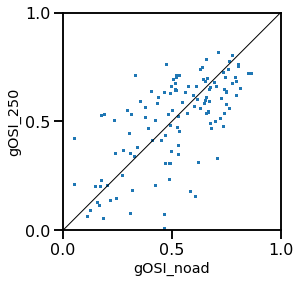

In [67]:
tmp1 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_noad.values
tmp2 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).gOSI_250.values
# tmp3 = df_tuning.sort_values(by=['gOSI_noad', 'gOSI_250'], ascending=False).tuning_bias.values

plt.scatter(tmp1, tmp2, alpha=.1, s=1);
plt.plot([0, 1], [0, 1], color='k', linestyle='-', linewidth=1); # draw diagonal line

plt.xlim([0, 1]);
plt.ylim([0, 1]);
plt.xticks([0, .5, 1]);
plt.yticks([0, .5, 1]);
plt.xlabel('gOSI_noad');
plt.ylabel('gOSI_250');
plt.gca().set_aspect('equal', adjustable='box'); # set axis square

## gOSI noad is usually higher. gOSI noad vs 250 is correlated

## filter cell well-max

48

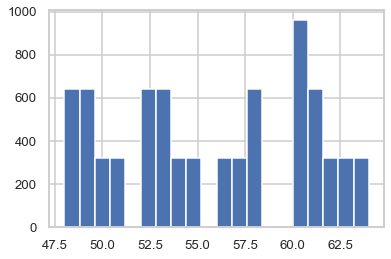

In [35]:
df_nrep = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
              .groupby(['cell_id', 'isi', 'stim2_id']).count() # count trials per cell, isi, ori
            )
plt.hist(df_nrep.values.flatten(), bins=20);
min(df_nrep.values.flatten())

In [102]:
## construct tuning_vec column

max_ori_bootstrap = np.array([])
nboot = 1000

for iboot in tqdm(range(nboot)):
    max_ori = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
                [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
                .groupby(['cell_id', 'isi', 'stim2_id'])
                .sample(n=36, random_state=iboot) # sample 30 trials per group. min rep = 48, so 30 is ok
                .groupby(['cell_id', 'isi', 'stim2_id'])
                .agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
                .groupby(['cell_id', 'isi']).apply(lambda x: np.argmax(x)) # get ori with max resp
                .reset_index() # NOTE: due to prev groupby, cell_id and isi are in order
                .rename(columns={0: 'max_ori'}).max_ori.values
                )
    max_ori_bootstrap = np.append(max_ori_bootstrap, max_ori)

  7%|▋         | 71/1000 [00:22<04:59,  3.10it/s]

In [70]:
max_ori_bootstrap = max_ori_bootstrap.reshape(nboot, -1) # reshape max_ori_bootstrap to: nboot x (ncell x nisi)

## sort max_ori_bootstrap in each col (across boots)
max_ori_bootstrap = np.sort(max_ori_bootstrap, axis=0)
# sns.heatmap(max_ori_bootstrap[:, 10:30], cmap='viridis', cbar=True, annot=True);

## query values at ith and (100-i)th percentile to see if their diff > 1
percentile = 5 # NOTE: strictness of well-max can be adjusted here
max_ori_boot_low = np.percentile(max_ori_bootstrap, percentile, axis=0)
max_ori_boot_high = np.percentile(max_ori_bootstrap, 100-percentile, axis=0)
max_ori_boot_var = max_ori_boot_high - max_ori_boot_low
max_ori_boot_var.shape # df_tidy.cell_id.nunique() x df_tidy.isi.nunique() = 160 x 3

## use max_ori_boot_var to get filter_cell_well_max
filter_cell_well_max = ((max_ori_boot_var <= 1) | (max_ori_boot_var == 7)) # 7 is equivalent to 1, due to circularity. NOTE: strictness of well-max can be adjusted here too
# plt.plot(max_ori_boot_var[10:30], color='k');
# plt.plot(filter_cell_well_max[10:30], color='r');

## merge filter_cell_well_max with df
df_well_max = (df_tidy[df_tidy.resp_id == 'R2'][['cell_id', 'isi']]
                .groupby(['cell_id', 'isi'])
                .first() # get first trial per cell, isi
                .reset_index() # due to prev groupby, cell_id and isi are in the same order as max_ori
                )
df_well_max['filter_cell_well_max'] = filter_cell_well_max
# df_well_max.filter_cell_well_max.sum() / df_well_max.shape[0]

df_well_max

,cell_id,isi,filter_cell_well_max
0,230622_1380_0,250,False
1,230622_1380_0,750,True
2,230622_1380_0,6000,False
3,230622_1380_1,250,True
4,230622_1380_1,750,True
...,...,...,...
475,230622_1380_98,750,False
476,230622_1380_98,6000,False
477,230622_1380_99,250,False
478,230622_1380_99,750,False


## filter cell ori-mod
dont fit tuning curve, dont filter well fit cells.  
find orientation-modulated cells by anova across all orientations responses

In [71]:
cell_property = (df_tidy[['cell_id', 'isi', 'area', 'filter_cell_vis']] # need cell info: area, vis driven
                 .groupby(['cell_id', 'isi']) # prepare to match with df_ori_mod
                 .first() # only take first value. all values should be the same for each cell and isi combination
                 .reset_index())
cell_property

,cell_id,isi,area,filter_cell_vis
0,230622_1380_0,250,V1,True
1,230622_1380_0,750,V1,True
2,230622_1380_0,6000,V1,True
3,230622_1380_1,250,V1,True
4,230622_1380_1,750,V1,True
...,...,...,...,...
475,230622_1380_98,750,V1,True
476,230622_1380_98,6000,V1,True
477,230622_1380_99,250,V1,True
478,230622_1380_99,750,V1,True


In [72]:
## construct tuning_vec column

df_ori_mod = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'resp_id', 'isi', 'stim2_id']]
              .groupby(['cell_id', 'isi', 'stim2_id']).agg({'dfof': 'mean'}) # aggregate resp by cell, isi, ori
              .groupby(['cell_id', 'isi']).agg({'dfof':lambda x: list(x)}) # each row is a list of aggregated resp across ori
              .reset_index()
              .rename(columns={'dfof': 'tuning_vec'})
              .merge(cell_property, on=['cell_id', 'isi'], how='left') # merge with cell info
            )

## construct ori_mod column

from scipy.stats import kruskal
p_threshold = 0.05

df_kruskal = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
            [['dfof', 'cell_id', 'isi', 'stim2_id']]
            .groupby(['cell_id', 'isi', 'stim2_id']) # for each cell, each isi condition, calc responses to each ori
            .agg({'dfof':lambda x: list(x)}) # each row, dfof col contains a list of ori responses across trials
            .reset_index()
            .groupby(['cell_id', 'isi']) # for each cell, each isi condition, calc ori modulation
            .apply(lambda x: kruskal(*x.dfof.values).pvalue < p_threshold) # kruskal, where each ori is a group
            .reset_index()
            )
df_kruskal = df_kruskal.rename(columns={0: 'ori_mod'}) # bool col for ori modulation

df_ori_mod = df_ori_mod.merge(df_kruskal, on=['cell_id', 'isi'], how='left')
df_ori_mod

,cell_id,isi,tuning_vec,area,filter_cell_vis,ori_mod
0,230622_1380_0,250,"[0.036960365777274115, 0.035508311137855325, 0...",V1,True,True
1,230622_1380_0,750,"[0.05268468549042758, 0.03113061766640703, 0.0...",V1,True,True
2,230622_1380_0,6000,"[0.045583698254903875, 0.04373528225916901, 0....",V1,True,True
3,230622_1380_1,250,"[0.03240139969373495, 0.02543606265484575, 0.0...",V1,True,False
4,230622_1380_1,750,"[0.031200432322993063, 0.028738791799870142, 0...",V1,True,False
...,...,...,...,...,...,...
475,230622_1380_98,750,"[0.00172867362175831, 0.005070494993649518, -0...",V1,True,False
476,230622_1380_98,6000,"[0.01191592452963748, 0.015427091298755186, 0....",V1,True,False
477,230622_1380_99,250,"[0.029024806851408447, 0.021120101684223232, 0...",V1,True,False
478,230622_1380_99,750,"[0.030942735890077396, 0.027580152454038276, 0...",V1,True,False


In [74]:
## construct max_ori and max_ori_distance column

df_ori_mod['max_ori'] = df_ori_mod.tuning_vec.apply(lambda x: np.argmax(x)) # NOTE: even though we calculated max_ori for isi 250 and 750, only isi 6000 was actually used below (inherited by df_lineplot)
df_ori_mod['max_ori_dist'] = df_ori_mod.max_ori.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # distance from 0 deg, hard coded for 8 ori. TODO: modify if needed

# df_ori_mod.groupby('max_ori').max_ori_distance.value_counts()
# df_ori_mod.groupby('max_ori_distance').max_ori.value_counts()
# df_ori_mod.groupby('max_ori').max_ori_dist.unique()

In [75]:
## prepare for lineplot. don't need tuning vec, but need (stim2_id, dfof) observations
df_lineplot = (df_tidy[df_tidy.resp_id == 'R2'] # only R2 has diff ori
                      [['dfof', 'cell_id', 
                        'area', 'filter_cell_vis',
                        'resp_id', 'isi', 'stim2_id']]
                        .reset_index(drop=True)
                        )

## inherit ori_mod, max_ori, max_ori_distance from df_ori_mod
df_lineplot = df_lineplot.merge(
      df_ori_mod[df_ori_mod.isi == 6000]
      [['cell_id', 'ori_mod', 'max_ori', 'max_ori_dist', ]], 
      on=['cell_id'], how='left') # only use isi 6000 (no adapter condition) to determine ori_mod, max_ori and max_ori_dist for each cell

## inherit df_well_max['filter_cell_well_max']
df_lineplot = df_lineplot.merge(
      df_well_max, 
      on=['cell_id', 'isi'], how='left') # take filter_cell_well_max from df_well_max, for each cell and isi

## inherit tuning_vec from df_ori_mod, for each isi
df_lineplot = df_lineplot.merge(
      df_ori_mod
      [['cell_id', 'tuning_vec', 'isi']],
      on=['cell_id', 'isi'], how='left') # take tuning_vec from df_ori_mod, for each cell and isi
df_lineplot

,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,filter_cell_well_max,tuning_vec
0,-0.013841,230622_1380_0,V1,True,R2,250,3,True,0,0.0,False,"[0.036960365777274115, 0.035508311137855325, 0..."
1,0.116145,230622_1380_0,V1,True,R2,6000,0,True,0,0.0,False,"[0.045583698254903875, 0.04373528225916901, 0...."
2,-0.010846,230622_1380_0,V1,True,R2,250,5,True,0,0.0,False,"[0.036960365777274115, 0.035508311137855325, 0..."
3,0.038692,230622_1380_0,V1,True,R2,6000,5,True,0,0.0,False,"[0.045583698254903875, 0.04373528225916901, 0...."
4,0.025417,230622_1380_0,V1,True,R2,6000,2,True,0,0.0,False,"[0.045583698254903875, 0.04373528225916901, 0...."
...,...,...,...,...,...,...,...,...,...,...,...,...
213435,-0.005935,230622_1380_159,V1,True,R2,250,7,False,1,22.5,False,"[0.011691870487159493, 0.020919699251222678, 0..."
213436,-0.004019,230622_1380_159,V1,True,R2,250,3,False,1,22.5,False,"[0.011691870487159493, 0.020919699251222678, 0..."
213437,0.000098,230622_1380_159,V1,True,R2,6000,6,False,1,22.5,False,"[0.034654556875529895, 0.05310167356877444, 0...."
213438,0.005295,230622_1380_159,V1,True,R2,6000,6,False,1,22.5,False,"[0.034654556875529895, 0.05310167356877444, 0...."


# tuning curve bias
no fitting, just align max response ori

In [76]:
df_lineplot['date'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[0])
df_lineplot['mouse'] = df_lineplot.cell_id.apply(lambda x: x.split('_')[1])
df_lineplot.groupby(['mouse', 'date']).first()

,,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,filter_cell_well_max,tuning_vec
mouse,date,,,,,,,,,,,,
1380,230622,-0.013841,230622_1380_0,V1,True,R2,250,3,True,0,0.0,False,"[0.036960365777274115, 0.035508311137855325, 0..."


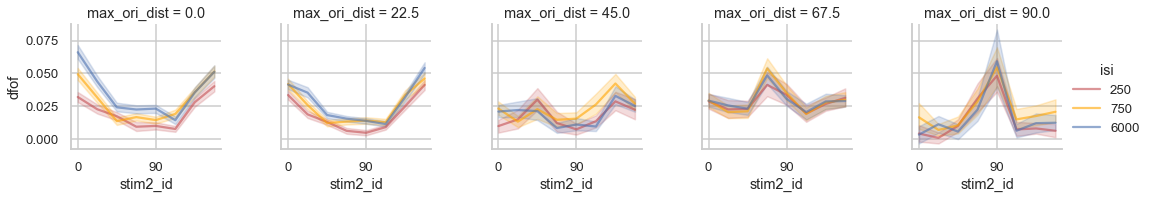

In [82]:
df_filter = df_lineplot[(df_lineplot.area == 'V1') # check V1 only
                    #    & (df_lineplot.isi != 750)
                    #    & (df_lineplot.ori_mod == True) # can turn this off, though i don't see obvious improvement
                       & (df_lineplot.filter_cell_well_max == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]

sns.set(font_scale=0.8, context='talk', style='whitegrid', palette=['r', 'orange', 'b'],)
g = sns.FacetGrid(df_filter, col="max_ori_dist", hue="isi")

g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.4, hspace=0.3)
g.add_legend();

# set xticks to 0, 4
for ax in g.axes.flat:
    ax.set_xticks([0, 4])
    ax.set_xticklabels(['0', '90'])

In [83]:
df_filter.groupby(['max_ori_dist']).cell_id.nunique()

max_ori_dist
0.0     33
22.5    48
45.0    15
67.5    12
90.0     7
Name: cell_id, dtype: int64

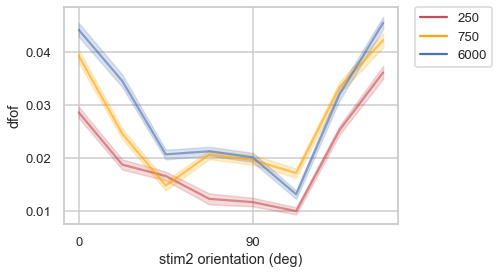

In [91]:
df_filter = df_lineplot[(df_lineplot.area == 'V1') # check V1 only
                    #    & (df_lineplot.ori_mod == True) # can also turn this off, though i don't see obvious improvement either
                       & (df_lineplot.filter_cell_well_max == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]

sns.lineplot(data=df_filter, x='stim2_id', y='dfof', hue='isi', ci=68, alpha=0.6, 
            # estimator=np.median, 
            estimator=np.mean, 
            palette=['r', 'orange', 'b'],)
plt.xticks([0, 4], ['0', '90'])
plt.xlabel('stim2 orientation (deg)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

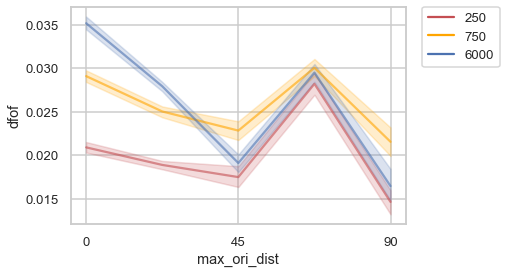

In [92]:
sns.lineplot(data=df_filter, x='max_ori_dist', y='dfof', hue='isi', ci=68, alpha=0.6, 
            estimator=np.mean, 
            palette=['r', 'orange', 'b'],)

plt.xticks([0, 45, 90], ['0', '45', '90'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

## norm by noad peak resp

In [93]:
## construct tuning_norm: take peak resp from tuning when isi=6000. norm tuning_vec by peak resp for all isi
df_lineplot['tuning_peak'] = df_lineplot.tuning_vec.apply(lambda x: np.max(x))

tmp = df_lineplot.groupby(['cell_id', 'isi']).tuning_vec.first().to_frame()
tmp.head(6)
max(tmp.iloc[2].tuning_vec), max(tmp.iloc[5].tuning_vec)

tmp_noad_peak = tmp.copy()
tmp_noad_peak['tuning_vec'] = tmp_noad_peak.tuning_vec.apply(lambda x: [max(x) for i in range(len(x))])
tmp_noad_peak = (tmp_noad_peak.groupby(level=['cell_id']).transform('last')) # copy last isi (6000) to all isi
tmp_noad_peak.head(6)
# noad_peak_val = tmp_noad_peak.tuning_vec.apply(lambda x: max(x)).values
# plt.hist(noad_peak_val, bins=20);

## split tuning_vec into 8 columns
tmp = tmp.tuning_vec.apply(pd.Series)
tmp.head(6)
# plt.hist(tmp.values.flatten(), bins=20);
# min(tmp.values.flatten()), max(tmp.values.flatten())

tmp_noad_peak = tmp_noad_peak.tuning_vec.apply(pd.Series)
tmp_noad_peak.head(6)

result = tmp / tmp_noad_peak # norm tuning_vec of all isi by max resp of isi=6000
result.head(6)
# plt.hist(result.values.flatten(), bins=50);
# min(result.values.flatten()), max(result.values.flatten())

thresh = 2 # NOTE: current norm (divided by noad peak resp) actually doesnt need much thresholding, as seen from histogram above
result = result.applymap(lambda x: x if abs(x) < thresh else np.nan) # threshold too large values - change to nan
result

result_noad = result.copy()
result_noad = (result_noad.groupby(level=['cell_id']).transform('last')) # copy last isi (6000) to all isi
result_noad.head(6)

result_diff = result - result_noad # subtract tuning_vec of isi=6000 from all isi
result_diff['tuning_norm_diff'] = result_diff.values.tolist()
result_diff.head(6)

## merge 8 columns back to tuning_vec
result['tuning_norm']= result.values.tolist()
result.head(6)

## merge tuning_norm back to df_lineplot -> for pref-adapter dist plot
df_lineplot = df_lineplot.loc[:, df_lineplot.columns != 'tuning_norm'].merge( # prevent duplicate column
        result.loc[:, 'tuning_norm'].reset_index(), # NOTE tuning_norm is (tuning_ad250 - tuning_noad)
        on=['cell_id', 'isi'], how='left')
df_lineplot.tail(6)

## merge tuning_norm_diff back to df_lineplot -> for stim2-adapter dist plot
df_lineplot = df_lineplot.loc[:, df_lineplot.columns != 'tuning_norm_diff'].merge( # prevent duplicate column
        result_diff.loc[:, 'tuning_norm_diff'].reset_index(), # NOTE tuning_norm is (tuning_ad250 - tuning_noad)
        on=['cell_id', 'isi'], how='left')
df_lineplot.tail(6)

,dfof,cell_id,area,filter_cell_vis,resp_id,isi,stim2_id,ori_mod,max_ori,max_ori_dist,filter_cell_well_max,tuning_vec,date,mouse,tuning_peak,tuning_norm,tuning_norm_diff
213434,0.036857,230622_1380_159,V1,True,R2,6000,7,False,1,22.5,False,"[0.034654556875529895, 0.05310167356877444, 0....",230622,1380,0.053102,"[0.6526076213143672, 1.0, 0.7653789180142471, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
213435,-0.005935,230622_1380_159,V1,True,R2,250,7,False,1,22.5,False,"[0.011691870487159493, 0.020919699251222678, 0...",230622,1380,0.049575,"[0.22017894543411726, 0.393955554416352, 0.574...","[-0.43242867588024997, -0.606044445583648, -0...."
213436,-0.004019,230622_1380_159,V1,True,R2,250,3,False,1,22.5,False,"[0.011691870487159493, 0.020919699251222678, 0...",230622,1380,0.049575,"[0.22017894543411726, 0.393955554416352, 0.574...","[-0.43242867588024997, -0.606044445583648, -0...."
213437,0.000098,230622_1380_159,V1,True,R2,6000,6,False,1,22.5,False,"[0.034654556875529895, 0.05310167356877444, 0....",230622,1380,0.053102,"[0.6526076213143672, 1.0, 0.7653789180142471, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
213438,0.005295,230622_1380_159,V1,True,R2,6000,6,False,1,22.5,False,"[0.034654556875529895, 0.05310167356877444, 0....",230622,1380,0.053102,"[0.6526076213143672, 1.0, 0.7653789180142471, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
213439,-0.047622,230622_1380_159,V1,True,R2,250,4,False,1,22.5,False,"[0.011691870487159493, 0.020919699251222678, 0...",230622,1380,0.049575,"[0.22017894543411726, 0.393955554416352, 0.574...","[-0.43242867588024997, -0.606044445583648, -0...."


In [95]:
df_filter = df_lineplot[(df_lineplot.area == 'V1') # check V1 only
                    #    & (df_lineplot.ori_mod == True) # turn ori_mod off makes better plot (fig 2E)
                       & (df_lineplot.filter_cell_well_max == True)
                       & (df_lineplot.filter_cell_vis == True)
                       ]

## df for pref-adapter dist plot
df_tuning_norm = (df_filter.groupby(['cell_id', 'isi'])
                  .tuning_norm.first().to_frame() # each cell and isi -> take first row
                  .tuning_norm.apply(pd.Series)
                  .rename(columns={i: 'stim2_id' + str(i) for i in range(8)}).reset_index() # rename columns by adding 'stim' to each column
                  .melt(id_vars=['cell_id', 'isi'], var_name='stim2_id', value_name='tuning_norm') # pivot table so stim is row
                  )

df_tuning_norm['stim2_id'] = df_tuning_norm.stim2_id.apply(lambda x: x[-1]).astype(int) # for stim col, take only the last char
df_tuning_norm['ori_dist'] = df_tuning_norm.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed. here, we dont align by max ori of cells (to group cells), instead we plot all cells

## inherit max_ori from df_lineplot
df_tuning_norm = (df_tuning_norm
                  .merge(df_filter[['cell_id', 'isi', 'max_ori', 'max_ori_dist']], on=['cell_id', 'isi'], how='inner')
                  .drop_duplicates() # TODO: why are there duplicates?
                  )
df_tuning_norm # NOTE: stim2_id and max_ori = index 0-7, while ori_dist and max_ori_dist unit = deg

## map with dict
ori_dist_bin = {0:0, 
                22.5:45,
                45:45,
                67.5:90,
                90:90,}

df_tuning_norm['ori_dist_bin'] = df_tuning_norm.ori_dist.map(ori_dist_bin)
df_tuning_norm['max_ori_dist_bin'] = df_tuning_norm.max_ori_dist.map(ori_dist_bin)
df_tuning_norm.cell_id.nunique() # how many cells

115

In [96]:
## df for pref-adapter dist plot
df_tuning_norm_diff = (df_filter.groupby(['cell_id', 'isi'])
                  .tuning_norm_diff.first().to_frame() # each cell and isi -> take first row
                  .tuning_norm_diff.apply(pd.Series)
                  .rename(columns={i: 'stim2_id' + str(i) for i in range(8)}).reset_index() # rename columns by adding 'stim' to each column
                  .melt(id_vars=['cell_id', 'isi'], var_name='stim2_id', value_name='tuning_norm_diff') # pivot table so stim is row
                  )

df_tuning_norm_diff['stim2_id'] = df_tuning_norm_diff.stim2_id.apply(lambda x: x[-1]).astype(int) # for stim col, take only the last char
df_tuning_norm_diff['ori_dist'] = df_tuning_norm_diff.stim2_id.apply(lambda x: 22.5*(8-x) if x > 4 else 22.5*x) # stim2 distance from 0 deg, hard coded for 8 ori. TODO: modify if needed. here, we dont align by max ori of cells (to group cells), instead we plot all cells

## inherit max_ori from df_lineplot
df_tuning_norm_diff = (df_tuning_norm_diff
                  .merge(df_filter[['cell_id', 'isi', 'max_ori', 'max_ori_dist']], on=['cell_id', 'isi'], how='inner')
                  .drop_duplicates() # TODO: why are there duplicates?
                  )
df_tuning_norm_diff # NOTE: stim2_id and max_ori = index 0-7, while ori_dist and max_ori_dist unit = deg

## map with dict
ori_dist_bin = {0:0, 
                22.5:45,
                45:45,
                67.5:90,
                90:90,}

df_tuning_norm_diff['ori_dist_bin'] = df_tuning_norm_diff.ori_dist.map(ori_dist_bin)
df_tuning_norm_diff['max_ori_dist_bin'] = df_tuning_norm_diff.max_ori_dist.map(ori_dist_bin)
df_tuning_norm_diff.cell_id.nunique() # how many cells

df_tuning_norm_diff

,cell_id,isi,stim2_id,tuning_norm_diff,ori_dist,max_ori,max_ori_dist,ori_dist_bin,max_ori_dist_bin
0,230622_1380_0,750,0,0.155779,0.0,0,0.0,0,0
456,230622_1380_0,750,1,-0.276517,22.5,0,0.0,45,0
912,230622_1380_0,750,2,0.002168,45.0,0,0.0,45,0
1368,230622_1380_0,750,3,-0.110336,67.5,0,0.0,90,0
1824,230622_1380_0,750,4,-0.388487,90.0,0,0.0,90,0
...,...,...,...,...,...,...,...,...,...
880736,230622_1380_97,6000,3,0.000000,67.5,6,45.0,90,45
881136,230622_1380_97,6000,4,0.000000,90.0,6,45.0,90,45
881536,230622_1380_97,6000,5,0.000000,67.5,6,45.0,90,45
881936,230622_1380_97,6000,6,0.000000,45.0,6,45.0,45,45


### Fig 2E: pref-adapter dist

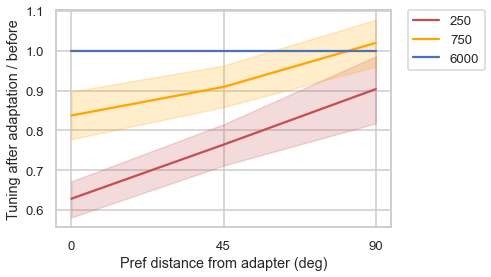

In [97]:
tmp = df_tuning_norm[df_tuning_norm.max_ori == df_tuning_norm.stim2_id] # only take rows with max ori id = stim2 ori id
tmp

sns.lineplot(data=tmp, x='max_ori_dist_bin', y='tuning_norm', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )

# set xticks 0, 45, 90
plt.xticks([0, 45, 90], [0, 45, 90])

plt.xlabel('Pref distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'Fig2E Jin2019.pdf', bbox_inches='tight')

max_ori_dist
0.0     33
22.5    48
45.0    15
67.5    12
90.0     7
Name: cell_id, dtype: int64

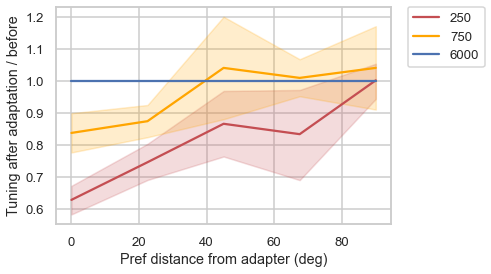

In [98]:
sns.lineplot(data=tmp, x='max_ori_dist', y='tuning_norm', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Pref distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'tuning_norm_lineplot_binned.pdf', bbox_inches='tight')

tmp.groupby(['max_ori_dist']).cell_id.nunique()

### Fig 2D: stim2-adapter dist

,cell_id,isi,stim2_id,tuning_norm_diff,ori_dist,max_ori,max_ori_dist,max_ori_dist_bin
ori_dist_bin,,,,,,,,
0,249,249,249,249,249,249,249,249
45,996,996,996,994,996,996,996,996
90,747,747,747,746,747,747,747,747


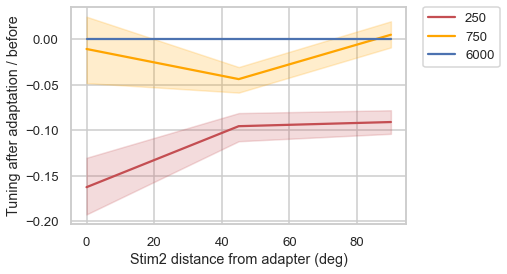

In [99]:
sns.lineplot(data=df_tuning_norm_diff, x='ori_dist_bin', y='tuning_norm_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Stim2 distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'tuning vs stim2_binned-adapter dist.pdf', bbox_inches='tight')

df_tuning_norm_diff.groupby(['ori_dist_bin']).count()

,cell_id,isi,stim2_id,tuning_norm_diff,max_ori,max_ori_dist,ori_dist_bin,max_ori_dist_bin
ori_dist,,,,,,,,
0.0,249,249,249,249,249,249,249,249
22.5,498,498,498,497,498,498,498,498
45.0,498,498,498,497,498,498,498,498
67.5,498,498,498,497,498,498,498,498
90.0,249,249,249,249,249,249,249,249


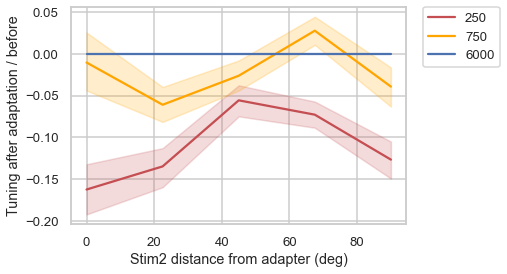

In [100]:
## set sns color palette
sns.lineplot(data=df_tuning_norm_diff, x='ori_dist', y='tuning_norm_diff', hue='isi', ci=68, #alpha=0.9,
            # estimator=np.median, 
            palette=['r', 'orange', 'b'],
            )
plt.xlabel('Stim2 distance from adapter (deg)')
plt.ylabel('Tuning after adaptation / before')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

dir_fig = r'C:\Users\ll357\Documents\inter\results\tuning curve bias san check/'.replace('\\', '/')
# plt.savefig(dir_fig + 'tuning vs stim2-adapter dist.pdf', bbox_inches='tight')
# plt.savefig(dir_fig + 'Fig2D Jin2019.pdf', bbox_inches='tight')

df_tuning_norm_diff.groupby(['ori_dist']).count()

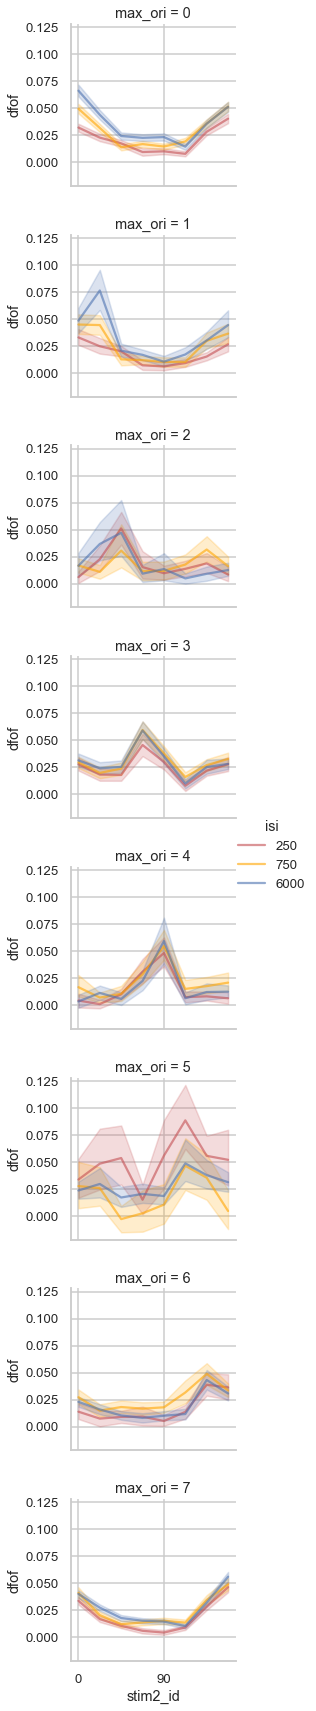

In [101]:
sns.set(font_scale=0.8, context='talk', style='whitegrid')
# g = sns.FacetGrid(df_filter, col="area", row="max_ori", hue="isi")
g = sns.FacetGrid(df_filter, row="max_ori", hue="isi", palette=['r', 'orange', 'b'], height=3, aspect=1.25)
g.map_dataframe(sns.lineplot, x="stim2_id", y="dfof", alpha=0.6)
g.figure.subplots_adjust(wspace=0.4, hspace=0.3)
g.add_legend();

for ax in g.axes.flat:
    ax.set_xticks([0, 4])
    ax.set_xticklabels(['0', '90'])